# Navigation

This notebook implements the navigation project that teaches an agent to pick up yellow bananas from a field of blue and yellow bananas

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

The unity files are in a the python folder which is loaded in this notebook.


In [1]:
import sys

import os

# the mock-0.3.1 dir contains testcase.py, testutils.py & mock.py
#sys.path.append('/tree/python/unityagents')

fileDir = os.path.dirname(os.path.realpath('__python__'))

#print(fileDir)

#filename = os.path.join(fileDir,'\python')

# Directory with files for Unity

filename = fileDir.replace("\p1_navigation","\python")

print(filename)

# Add to system path files for Unity
sys.path.append(filename)

#sys.path.append(r"C:\Users\pgarcia\Documents\GitHub\Udacity-Reinforcement-Learning\deep-reinforcement-learning-master\Repo-Navigation-Project1\python")

#from unityagents import UnityEnvironment

from unityagents import UnityEnvironment
import numpy as np

C:\Users\pgarcia\Documents\GitHub\Udacity-Reinforcement-Learning\deep-reinforcement-learning-master\Repo-Navigation-Project1\p1_navigation
C:\Users\pgarcia\Documents\GitHub\Udacity-Reinforcement-Learning\deep-reinforcement-learning-master\Repo-Navigation-Project1\python


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [3]:
env = UnityEnvironment(file_name=r"C:\Users\pgarcia\Documents\GitHub\Udacity-Reinforcement-Learning\deep-reinforcement-learning-master\p1_navigation\Banana_Windows_x86_64\Banana_Windows_x86_64\banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
brain_name

'BananaBrain'

In [6]:
brain.vector_observation_space_size

37

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Define Network and Train Agent

Define Q value network that maps states to action values using a two layer CNN with 64 nodes each. RELU functions are used to activate each of the hidden layers. 

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

Define an agent with 37 state observations and 4 actions. 

In [9]:
from dqn_agent_banana import Agent

agent = Agent(state_size=37, action_size=4, seed=0)

Implement complete algorithm to explore the space and learn from the experiments. The exercise is completed when the agent obtains an average of 13 over 100 episodes

In [13]:
from collections import deque

env_info = env.reset(train_mode=True)[brain_name]

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start# initialize epsilon

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
#        print(type(state))
#        print(state)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            action = action.astype(np.int32)
#            next_state, reward, done, _ = env.step(action)
#            action = np.random.randint(action_size)        # select an action
#            print(t)
            env_info = env.step(action)[brain_name] # send the action to the environment#
#            env_info = env_info.astype(np.int32)
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'model_weights.pth')
            
    return scores


In [ ]:
scores = dqn()

In [14]:
# agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))


Episode 100	Average Score: 0.37
Episode 200	Average Score: 4.05
Episode 300	Average Score: 5.74
Episode 400	Average Score: 9.61
Episode 500	Average Score: 12.87
Episode 568	Average Score: 13.53
Environment solved in 468 episodes!	Average Score: 13.53


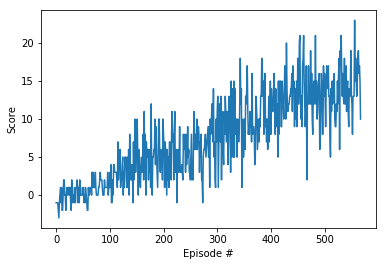

In [18]:
from matplotlib import pyplot as plt

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()